# CPE

**Common Platform Enumeration (CPE)** is a structured naming scheme for information technology systems, software, and packages. Based upon the generic syntax for Uniform Resource Identifiers (URI), CPE includes a formal name format, a method for checking names against a system, and a description format for binding text and tests to a name. This method of naming is known as a well-formed CPE name (WFN)

> source: [https://cpe.mitre.org/specification/](https://cpe.mitre.org/specification/)



You can see this notebook directly via:
- [GitHub](https://github.com/LimberDuck/limberduck.org/blob/master/docs/notebooks/cpe/cpe.ipynb)
- [Jupter nbviewer](https://nbviewer.org/github/LimberDuck/limberduck.org/blob/master/docs/notebooks/cpe/cpe.ipynb)

## CPE data downloading

All CPE stats are taken from [https://nvd.nist.gov/products/cpe/statistics](https://nvd.nist.gov/products/cpe/statistics)

In [1]:
from urllib.request import urlopen
import ssl
from bs4 import BeautifulSoup, SoupStrainer

def get_data(url):

    ctx = ssl.create_default_context()
    ctx.check_hostname = False
    ctx.verify_mode = ssl.CERT_NONE

    page = urlopen(url, context=ctx)
    html = page.read().decode("utf-8")
    
    product = SoupStrainer('table')
    soup = BeautifulSoup(html, "html.parser", parse_only=product)
    
    return soup

url = "https://nvd.nist.gov/products/cpe/statistics"
data = get_data(url)

print(len(data))

13


## New CPE entries

### CPE data parsing

In [2]:
import pandas as pd

def pars(data):
    data_table = []
    
    for table in data:
        table_id = table['id']
        table_year = table_id[-4:]
        table_rows = table.find_all("tr")
        number_of_new_cpe_entries_yearly = 0
        number_of_new_cpe_entries_list = []
        data_row = []
        for table_row in table_rows:
            data = table_row.find_all("td")
            
            if data:
                number_of_new_cpe_entries = int(data[1].string.replace(",",""))
                
                number_of_new_cpe_entries_list.append(number_of_new_cpe_entries)
                
                number_of_new_cpe_entries_yearly += number_of_new_cpe_entries
        
        while len(number_of_new_cpe_entries_list) < 12:
            number_of_new_cpe_entries_list.append(0)

        data_row.append(table_year)
        data_row.append(number_of_new_cpe_entries_yearly)
        data_row = data_row + number_of_new_cpe_entries_list

        data_table.append(data_row)
    
    data_columns = ['Year', 'Summary', 'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    df = pd.DataFrame (data_table, columns = data_columns)
    df.sort_values(by=['Year'], inplace=True)    
    df.reset_index(drop=True, inplace=True)
    df.index += 1
    return df
    
parsed_data = pars(data)

parsed_data.style.bar(subset=['Summary'], color='#FF6200')



,Year,Summary,January,February,March,April,May,June,July,August,September,October,November,December
1,2009,5786,181,422,830,639,612,209,241,110,330,102,1960,150
2,2010,11094,990,234,509,1106,803,886,426,1252,707,1336,1026,1819
3,2011,9263,702,925,583,2252,818,682,430,390,423,470,737,851
4,2012,23235,1148,1003,1622,2501,3228,2259,3124,2887,1583,1830,1110,940
5,2013,15671,1460,1105,1138,1271,932,989,1623,1359,1140,1941,1327,1386
6,2014,16714,1552,1151,1644,2103,2175,1447,1606,886,885,260,1380,1625
7,2015,6503,758,654,849,838,429,736,446,564,81,216,144,788
8,2016,11081,2450,535,871,699,733,1474,321,762,979,455,696,1106
9,2017,18673,746,888,1075,1936,1499,1216,1366,1890,1517,1596,2587,2357
10,2018,56530,2276,2405,1578,2525,10491,5163,3707,3896,3723,10862,6567,3337


### CPE data saving

CSV file is available in GitHub repository [here](https://github.com/LimberDuck/limberduck.org/blob/master/docs/notebooks/cpe/cpe-number-of-new-entries.csv).

In [3]:
csv_filename = 'cpe-number-of-new-entries.csv'

parsed_data.to_csv(csv_filename, index=False)

### CPE data ploting

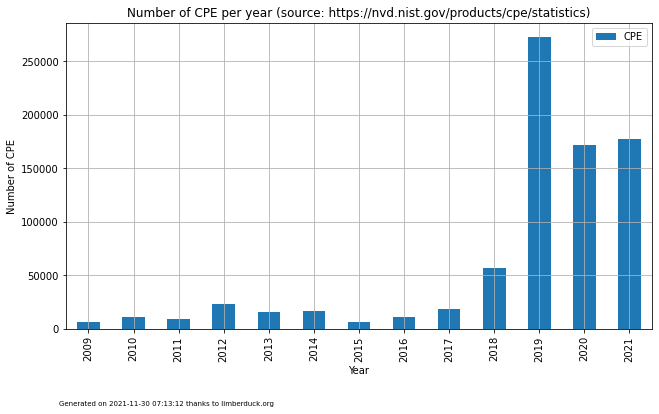

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime

df = pd.read_csv(csv_filename)

# print(df)

df.plot(x='Year', 
        xlabel='Year',
        y='Summary', 
        ylabel='Number of CPE',
        kind='bar', 
        title='Number of CPE per year (source: https://nvd.nist.gov/products/cpe/statistics)')
plt.tight_layout()
plt.legend(['CPE'])
plt.figtext(0.45, 0.02, f"Generated on {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')} thanks to limberduck.org", ha="right", fontsize=7)
fig = plt.gcf()
fig.set_size_inches(10,6)
fig.patch.set_facecolor('white')
plt.grid(True)
plt.savefig('cpe-number-of-new-entries-bg-white.png', dpi = 300, facecolor = 'white')
plt.savefig('cpe-number-of-new-entries-bg-transparent.png', dpi = 300, transparent = True)